In [1]:
from pybsd import *
import numpy as np
from jax import numpy as jnp 
from jax import grad, hessian, jit
from collections import OrderedDict

In [52]:
class BSD(VariationalLaplaceEstimator):
    def __init__(self, Hz, freqs, *args, **kwargs): 
        pE, pC = self._prepare(freqs)
        self.Hz = jnp.asarray(Hz)
        
        hE = jnp.array([10])
        hC = jnp.array([1/256])
        Q = jnp.eye(self.Hz.size)
        
        super().__init__(pE, pC, hE, hC, Q, *args, **kwargs)
        
    def _prepare(self, freqs):
        freqs = jnp.asarray(freqs)
        
        if len(freqs.shape) == 1:
            freqs = jnp.expand_dims(freqs, 0)
            
        if freqs.shape[1] != 2: 
            raise ValueError(f'Incorrect number of dimensions on frequency array.'
                             f' Expecting (nfreqs, 2), got {freqs.shape}.')
        
        nf = freqs.shape[0]
        W = (freqs[:, 1] - freqs[:, 0]).reshape((-1,1))
        S = W**2 / (8 * jnp.log(2))
        
        self.freqs = freqs
        self.nf = nf
        self.S = S
        self.W = W
        
        a = 0 * W
        b = jnp.zeros((2,1))
        
        pE = OrderedDict(
            f=0*W,
            S=0*S, 
            a=a, 
            b=b
        )
        pC = OrderedDict(
            f=0*W + 1,
            S=0*S + 2, 
            a=0*a + 2, 
            b=0*b + 1
         )
        self._pStruct = pE
        
        return vectorize(pE), vectorize(pC)
        
    
    def param2spec(self, P): 
        spec = OrderedDict()

        # forward: a
        if 'a' in P:
            spec['ampl'] = jnp.exp(P['a'])

        # forward: f
        if 'f' in P:
            spec['freq'] = self.freqs[:, [0]] + (0.5 + 0.5 * jnp.tanh(P['f'])) * (self.W)

        # forward: S
        if 'S' in P:
            spec['fwhm'] = jnp.sqrt(jnp.exp(P['S']) * self.S * 8 * jnp.log(2))

        # forward: b
        if 'b' in P:
            spec['noise'] = jnp.array([jnp.exp(P['b'])[0], -jnp.exp(P['b'])[1]])

        return spec
    
    def spec2param(self, **spec):
        try: 
            P = spec.pop('P')
        except:
            P = self._pStruct

        # forward: a = exp(P.a);
        if 'ampl' in spec:
            if jnp.any(spec['ampl'] < 0):
                print('Warning: Negative amplitude!')
            P['a'] = jnp.log(spec['ampl'])

        # forward: f = M.pV.f[:, 1] + (0.5 + 0.5 * tanh(P.f)) * (M.pV.f[:, 2] - M.pV.f[:, 1]);
        if 'freq' in spec:
            if jnp.any(spec['freq'] < 0):
                print('Warning: Negative frequency!')
            P['f'] = jnp.arctanh(2 * (spec['freq'] - self.freqs[:, 0]) / (self.W) - 1)

        # forward: S = exp(P.S) * M.pV.S;
        if 'fwhm' in spec:
            if jnp.any(spec['fwhm'] < 0):
                print('Warning: Negative FWHM!')
            S = (spec['fwhm'] ** 2) / (8 * jnp.log(2))
            P['S'] = jnp.log(S) - jnp.log(self.S)

        # forward: b = exp(P.b) * M.pV.b;
        if 'noise' in spec:
            P['b'] = jnp.log(jnp.abs(spec['noise']))

        return P
        
    def forward(self, p):
        p = unvectorize(p, self._pStruct)
        spec = self.param2spec(p)

        f = spec['freq']; 
        a = spec['ampl']; 
        S = spec['fwhm']**2/(8 * jnp.log(2)); 
        b = spec['noise']; 
        Hc = jnp.vecdot(a, jnp.exp(-(self.Hz.reshape((1,-1))- f)**2/(2*S)), axis=0)
        Hc +=  b[0] * self.Hz**b[1]
        
        return Hc
        

In [53]:
Hz = [*range(1,32)]
freqs = [[8, 12], [14,24]]

bsd = BSD(Hz, freqs, atol=5e-1)

In [54]:
P = vectorize(bsd.spec2param(ampl=np.array([1, 0.5])))

In [55]:
Y = bsd.forward(P)+0.1*np.random.normal(size=bsd.Hz.shape)**2

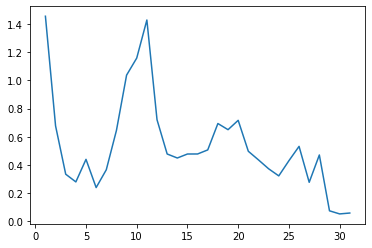

In [56]:
import matplotlib.pyplot as plt
plt.plot(bsd.Hz, Y.squeeze())

In [57]:
res = bsd.fit(Y, qE=bsd._pE)

EM: (+) 0: F-F0: 0.00e+00 dF (predicted): 0.00e+00 (actual): 1.13e+01 (2.74 ms)
EM: (+) 1: F-F0: 1.13e+01 dF (predicted): 0.00e+00 (actual): 6.92e-02 (2.01 ms)
EM: (+) 2: F-F0: 1.14e+01 dF (predicted): 0.00e+00 (actual): 0.00e+00 (1.91 ms)
EM: (-) 3: F-F0: 1.14e+01 dF (predicted): 0.00e+00 (actual): 0.00e+00 (1.91 ms)
EM: (-) 4: F-F0: 1.14e+01 dF (predicted): 0.00e+00 convergence.


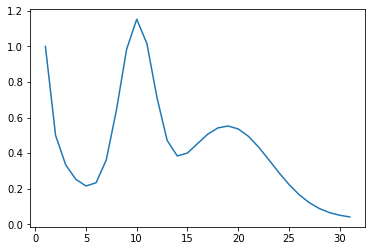

In [58]:
import matplotlib.pyplot as plt
plt.plot(bsd.Hz, bsd.forward(res['Ep']).squeeze())